In [1]:
import pandas as pd
from copy import deepcopy
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
from scipy.stats import yeojohnson, rankdata
from sklearn.base import clone
import numpy as np
from sklearn import preprocessing
import warnings
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def add_transform_col(df, col, transform_name, transformed_name, group_col=None):
    # modified code from RS3 dev
    df = df.copy()
    min_group_size = df.groupby(group_col).size().min() if group_col else len(df)

    transforms = {
        'min-max-scaler': preprocessing.MinMaxScaler(),
        'robust-scaler': preprocessing.RobustScaler(),
        'quantile-uniform': preprocessing.QuantileTransformer(random_state=123, n_quantiles=min_group_size),
        'quantile-normal': preprocessing.QuantileTransformer(random_state=123, output_distribution='normal', n_quantiles=min_group_size),
        'z-score': preprocessing.StandardScaler()
    }

    if transform_name == 'yeo-johnson':
        if group_col is None:
            df[transformed_name] = yeojohnson(df[col])[0]
        else:
            df[transformed_name] = df.groupby(group_col)[col].transform(lambda x: yeojohnson(x)[0])
    elif transform_name == 'rank':
        if group_col is None:
            df[transformed_name] = rankdata(df[col])
        else:
            df[transformed_name] = df.groupby(group_col)[col].transform(lambda x: rankdata(x))
    elif transform_name == 'percentile':
        if group_col is None:
            df[transformed_name] = rankdata(df[col]) / len(df[col])
        else:
            df[transformed_name] = df.groupby(group_col)[col].transform(lambda x: rankdata(x) / len(x))
    elif transform_name in transforms:
        transform = transforms[transform_name]
        if group_col is None:
            df[transformed_name] = clone(transform).fit_transform(df[[col]])[:, 0]
        else:
            df[transformed_name] = df.groupby(group_col)[col].transform(lambda x: clone(transform).fit_transform(x.to_frame())[:, 0])
    else:
        raise ValueError(f"Unknown transform_name: {transform_name}")

    return df

# Function to compute correlations for each transformation and phenotype
def compute_correlations(df, columns_info, other_pheno_except_zscore,corr_type = 'pearson'):
    
    
    correlation_results = []
    processed_pairs = set()

    for transformation in columns_info['transformation'].unique():
        for phenotype in columns_info['phenotype'].unique():
            columns_subset = columns_info[
                (columns_info['transformation'] == transformation) &
                (columns_info['phenotype'] == phenotype)
            ]['column']
            if not columns_subset.empty:
                if phenotype == 'ScaledZscore':
                    # Only consider correlations within the same phenotype of ScaledZscore
                    corr = df[columns_subset].corr(corr_type)
                else:
                    # Consider correlations across different phenotypes ScaledLFC ScaledRho
                    other_columns_subset = columns_info[
                        (columns_info['transformation'] == transformation) &
                        (columns_info['phenotype'].isin(other_pheno_except_zscore))
                    ]['column']
                    corr = df[other_columns_subset].corr(corr_type).loc[other_columns_subset, other_columns_subset]
                    
                    
                for col1 in corr.columns:
                    for col2 in corr.index:
                        if col1 != col2 and col1.split('_')[0] != col2.split('_')[0] and (col2, col1) not in processed_pairs:
                            processed_pairs.add((col1, col2))
                            correlation_results.append({
                                'Column1': col1,
                                'Column2': col2,
                                'Correlation': corr.loc[col2, col1]
                            })
    
    correlation_df = pd.DataFrame(correlation_results)
    return correlation_df.drop_duplicates().sort_values('Correlation',ascending = True)
# Function to split and extract the necessary parts
def extract_parts(row):
    col1_parts = row['Column1'].split('_')
    col2_parts = row['Column2'].split('_')
    dataset_comparison = f"{col1_parts[0]} vs {col2_parts[0]}"
    phenotype = f"{col1_parts[1]} vs {col2_parts[1]}"
    transformation = col1_parts[2]
    return pd.Series([dataset_comparison, phenotype, transformation, row['Correlation']], index=['DatasetComparison', 'Phenotype', 'Transformation', 'Correlation'])

def yhat(df, org_x, org_y):
    x = df[org_x]
    y = df[org_y]
    
    # Adding a constant for the intercept term
    x = sm.add_constant(x)
    
    # Fit the model
    model = sm.OLS(y, x).fit()
    
    # Extracting parameters
    intercept, slope = model.params
    p_value = model.pvalues[1]  # p-values[1] corresponds to the slope
    print(f'pVal of slope: {p_value}')
    print(f'intercept: {intercept} and slope: {slope}')
    yhat_name = org_x +'_hat'
    df[yhat_name] = df[org_x]*slope + intercept

    return df
def plot_byGene_andEntire(df, x, y, plot = True,corr_type = 'pearson'):
    graphName = x + ' vs ' + y
    plt.subplots(figsize=(4,4))
    gpplot.point_densityplot(data=df, 
                             x=x, y=y)
    gpplot.add_correlation(data=df, 
                           x=x, y=y, 
                           method=corr_type)
    sns.despine()
    if plot:
        plt.savefig(graph_pathout + graphName + ".pdf", dpi=300, bbox_inches='tight')
    else:
        pass
    

In [3]:
graph_pathout = '../Figure/Figure 3/Individual Figures/'

In [4]:
cleanedAllData_path = '../Data/CleanedExternalData/'
NewDatasetCombine = pd.read_csv(cleanedAllData_path + 'DatasetCombineCleaned_v3.csv', low_memory=False)
NewDatasetCombine['sgRNA Context Sequence'] = NewDatasetCombine['sgRNA Context Sequence'].apply(lambda x: x.upper())

NewDatasetCombineInHouse = NewDatasetCombine[(NewDatasetCombine.DataSet == 'InHouse')].copy()#.groupby('Domain')
NewDatasetCombineInHouseAvgDomain = NewDatasetCombineInHouse.groupby([ 'Target Gene Symbol', 'chromosome', 'sgRNA Sequence',
       'sgRNA Context Sequence', 'sgRNA \'Cut\' Position', 'Strand of Target',
       'TSS Position', 'sgRNA \'Cut\' Site TSS Offset','Domain'])['z_scored_avg_lfc'].mean().reset_index()
# only selecting the InHouse dataset because I want InHouse and Gilbert to be on the same scale
# I used Kox1 because Gilbert also use Kox1. 
NewDatasetCombineInHouseKox1 = NewDatasetCombineInHouseAvgDomain[(NewDatasetCombineInHouseAvgDomain.Domain == 'Kox1') ]
NewDatasetCombineInHouseKox1 = NewDatasetCombineInHouseKox1.rename(columns = {'z_scored_avg_lfc': 'AveragedZscoreKox1InHouse'})

# import inhouse data with LFC 
inhouseLFC_path = "../Data/PrimaryLibrary/processed_z_score/"
inhouseLFC = pd.read_csv(inhouseLFC_path + "inHouseDatasetsCombined.csv")
inhouseLFC['avgLFC_A549Kox1'] = inhouseLFC[['avg_lfc_A549_Kox1' ,'avg_lfc_HCT116_Kox1']].mean(axis=1)
inhouseLFC = inhouseLFC[['Target Gene Symbol', 'sgRNA Context Sequence', 'avgLFC_A549Kox1','Category']]

# combine to have LFC
NewDatasetCombineInHouseKox1 = pd.merge(NewDatasetCombineInHouseKox1,inhouseLFC )
NewDatasetCombineInHouseKox1_keepcol = ['Target Gene Symbol','sgRNA Context Sequence', 'AveragedZscoreKox1InHouse', 'avgLFC_A549Kox1','Category']
NewDatasetCombineInHouseKox1 = NewDatasetCombineInHouseKox1[NewDatasetCombineInHouseKox1_keepcol]
NewDatasetCombineInHouseKox1 = NewDatasetCombineInHouseKox1[NewDatasetCombineInHouseKox1.Category == 'Essential']


In [5]:
# Nunez
combinedNunez = NewDatasetCombine[NewDatasetCombine.DataSet == 'Nunez'].copy()
combinedNunez_keepcol = ['Target Gene Symbol','sgRNA Context Sequence', 'Phenotype scores-ave_Rep1_Rep2', 'z-score relative to NC', 'Avg_LFC-Tfinal']
combinedNunez = combinedNunez[combinedNunez_keepcol]


In [6]:
# List of transformations
transforms = ['yeo-johnson', 'quantile-uniform', 'robust-scaler', 'min-max-scaler', 
              'quantile-normal','z-score','rank', 'percentile']

# Apply transformation to Phenotype scores-ave_Rep1_Rep2, z-score relative to NC, Avg_LFC-Tfinal
for transform in transforms:
    NewDatasetCombineInHouseKox1 = add_transform_col(NewDatasetCombineInHouseKox1, 'avgLFC_A549Kox1', transform, f'InHouse_ScaledLFC_{transform}', group_col='Target Gene Symbol')
    NewDatasetCombineInHouseKox1 = add_transform_col(NewDatasetCombineInHouseKox1, 'AveragedZscoreKox1InHouse', transform, f'InHouse_ScaledZscore_{transform}', group_col='Target Gene Symbol')
    combinedNunez = add_transform_col(combinedNunez, 'Avg_LFC-Tfinal', transform, f'Nunez_ScaledLFC_{transform}', group_col='Target Gene Symbol')
    combinedNunez = add_transform_col(combinedNunez, 'z-score relative to NC', transform, f'Nunez_ScaledZscore_{transform}', group_col='Target Gene Symbol')
    combinedNunez = add_transform_col(combinedNunez, 'Phenotype scores-ave_Rep1_Rep2', transform, f'Nunez_ScaledPhenoScore_{transform}', group_col='Target Gene Symbol')

# merge inhouse and nunez together using common context seq and gene
samegRNAInHouseNunez = pd.merge(combinedNunez, 
         NewDatasetCombineInHouseKox1,
                               on = ['Target Gene Symbol', 'sgRNA Context Sequence'])
len(samegRNAInHouseNunez)

6789

In [7]:
# only keeping the transformed phenotype
remove_col = NewDatasetCombineInHouseKox1_keepcol + combinedNunez_keepcol
samegRNAInHouseNunez_phenotype = samegRNAInHouseNunez.drop(remove_col, axis=1)
# Extract dataset, phenotype, and transformation information
columns_info = samegRNAInHouseNunez_phenotype.columns.str.extract(r'(?P<dataset>[^_]+)_(?P<phenotype>[^_]+)_(?P<transformation>[^_]+)')
columns_info['column'] = samegRNAInHouseNunez_phenotype.columns
# Compute correlations
correlations = compute_correlations(samegRNAInHouseNunez, columns_info,['ScaledLFC', 'ScaledPhenoScore'])
correlations

,Column1,Column2,Correlation
22,Nunez_ScaledZscore_quantile-normal,InHouse_ScaledZscore_quantile-normal,0.508815
20,Nunez_ScaledLFC_quantile-normal,InHouse_ScaledLFC_quantile-normal,0.509417
21,Nunez_ScaledPhenoScore_quantile-normal,InHouse_ScaledLFC_quantile-normal,0.513855
2,Nunez_ScaledZscore_yeo-johnson,InHouse_ScaledZscore_yeo-johnson,0.544180
36,Nunez_ScaledPhenoScore_percentile,InHouse_ScaledLFC_percentile,0.556283
35,Nunez_ScaledLFC_percentile,InHouse_ScaledLFC_percentile,0.557709
37,Nunez_ScaledZscore_percentile,InHouse_ScaledZscore_percentile,0.558188
6,Nunez_ScaledPhenoScore_quantile-uniform,InHouse_ScaledLFC_quantile-uniform,0.559914
5,Nunez_ScaledLFC_quantile-uniform,InHouse_ScaledLFC_quantile-uniform,0.562619
7,Nunez_ScaledZscore_quantile-uniform,InHouse_ScaledZscore_quantile-uniform,0.563162


In [8]:
# Apply the function to each row
correlations_new = correlations.apply(extract_parts, axis=1)
correlations_new.to_csv('../Data/CleanedScaledData/Correlation/correlationsNunezInHouse.csv',
                       index = False)

In [9]:
correlations_new

,DatasetComparison,Phenotype,Transformation,Correlation
22,Nunez vs InHouse,ScaledZscore vs ScaledZscore,quantile-normal,0.508815
20,Nunez vs InHouse,ScaledLFC vs ScaledLFC,quantile-normal,0.509417
21,Nunez vs InHouse,ScaledPhenoScore vs ScaledLFC,quantile-normal,0.513855
2,Nunez vs InHouse,ScaledZscore vs ScaledZscore,yeo-johnson,0.544180
36,Nunez vs InHouse,ScaledPhenoScore vs ScaledLFC,percentile,0.556283
35,Nunez vs InHouse,ScaledLFC vs ScaledLFC,percentile,0.557709
37,Nunez vs InHouse,ScaledZscore vs ScaledZscore,percentile,0.558188
6,Nunez vs InHouse,ScaledPhenoScore vs ScaledLFC,quantile-uniform,0.559914
5,Nunez vs InHouse,ScaledLFC vs ScaledLFC,quantile-uniform,0.562619
7,Nunez vs InHouse,ScaledZscore vs ScaledZscore,quantile-uniform,0.563162


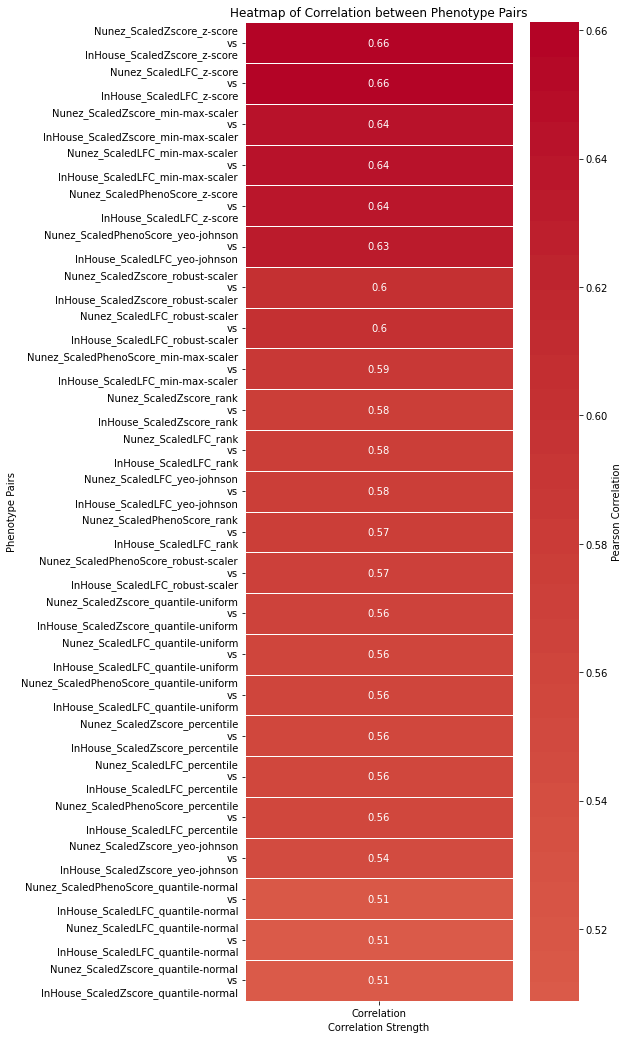

In [10]:
# Combine col1 and col2 into a single column with newlines
correlations['col_pair'] = correlations['Column1'] + '\nvs\n' + correlations['Column2']

# Create a pivot table with the combined pairs as the index and correlation values as the single column
pivot_table = correlations.pivot_table(index='col_pair', values='Correlation')
pivot_table = pivot_table.reindex(pivot_table['Correlation'].abs().sort_values(ascending=False).index)

# Plot the heatmap
plt.figure(figsize=(6, 18))  
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Pearson Correlation'}, linewidths=0.5)
plt.title('Heatmap of Correlation between Phenotype Pairs')
plt.xlabel('Correlation Strength')
plt.ylabel('Phenotype Pairs')
plt.savefig(graph_pathout + "NunezScalingCorr.pdf", dpi=300, bbox_inches='tight')

plt.show()

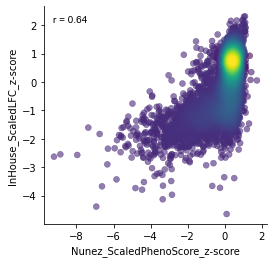

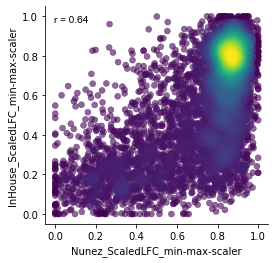

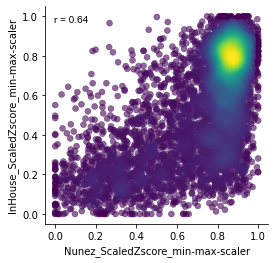

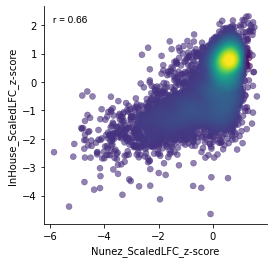

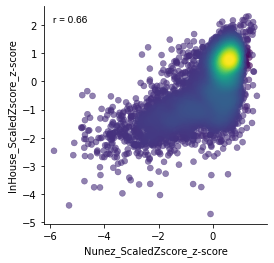

In [11]:
correlationsHigh = correlations.tail(5)
for index, row in correlationsHigh.iterrows():
    plot_byGene_andEntire(samegRNAInHouseNunez, row['Column1'], row['Column2'])

    

In [12]:
# seems like scaledZscore_zscore is good for both nunez and Gilbert

pVal of slope: 0.0
intercept: -0.020729378351417135 and slope: 0.6167897333797373
pVal of slope: 0.0
intercept: 0.025296774675839222 and slope: 0.7539550269193225
pVal of slope: 0.0
intercept: 0.024090641442680538 and slope: 0.7560022667980668
pVal of slope: 0.0
intercept: -0.017144756835945338 and slope: 0.6429991268680099
pVal of slope: 0.0
intercept: -0.016824368329855045 and slope: 0.6434199320893981


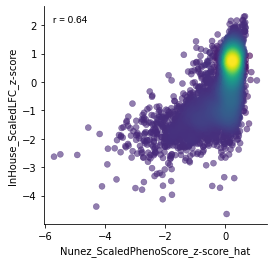

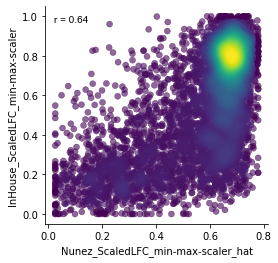

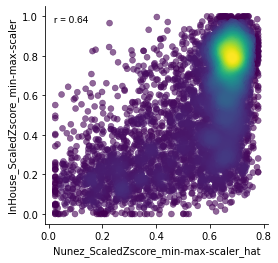

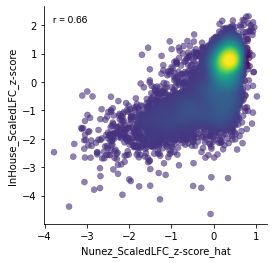

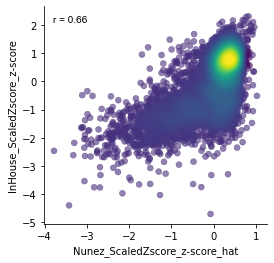

In [13]:
for index, row in correlationsHigh.iterrows():
    x = row['Column1']
    y = row['Column2']
    samegRNAInHouseNunez = yhat(samegRNAInHouseNunez, x,y)
    plot_byGene_andEntire(samegRNAInHouseNunez, f'{x}_hat', y, False,'pearson')
    

In [14]:
len(NewDatasetCombineInHouseKox1)

42104

In [15]:
nunezScaledData = combinedNunez[['Target Gene Symbol', 'sgRNA Context Sequence',
       'Nunez_ScaledZscore_z-score']].copy()
nunezScaledData['Domain'] = 'Kox1'
nunezScaledData['DataSet'] = 'Nunez'
nunezScaledData = nunezScaledData.rename(columns = {'Nunez_ScaledZscore_z-score': 'doubleZscore'} )

In [16]:
inHouseKox1ScaledData = NewDatasetCombineInHouseKox1[['Target Gene Symbol', 'sgRNA Context Sequence','InHouse_ScaledZscore_z-score']].copy()
inHouseKox1ScaledData['Domain'] = 'Kox1'
inHouseKox1ScaledData['DataSet'] = 'InHouse'
inHouseKox1ScaledData = inHouseKox1ScaledData.rename(columns = {'InHouse_ScaledZscore_z-score': 'doubleZscore'} )


In [17]:
dataOut = '../Data/CleanedScaledData/'
nunezScaledData.to_csv(dataOut+'nunezScaledData.csv', index = False)

In [18]:
inHouseKox1ScaledData.to_csv(dataOut+'inHouseKox1ScaledData.csv', index = False)